# Eye State Detection Train Test Split

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd

random_seed = 123
np.random.seed(random_seed)

import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/kaggle/EEG_Eye_State.csv")

X = train.sample(frac=1).copy()
y = X.pop("eyeDetection")

In [30]:
train.shape

(14980, 15)

### Preprocess features

First we remove the outliers and fit a StandardScaler on the dataset. 

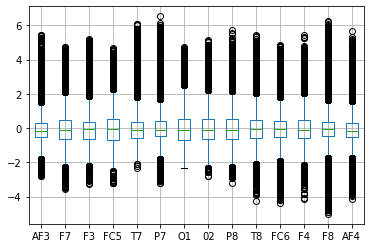

In [31]:
from scipy import stats
from sklearn import preprocessing

nonoutliers = (np.abs(stats.zscore(X)) < 3).all(axis=1)
X_clean = X[nonoutliers]
y_clean = y[nonoutliers]

scaler = preprocessing.StandardScaler()
scaler.fit(X_clean)
X_norm = pd.DataFrame(scaler.transform(X_clean),columns=X_clean.columns)

X_norm.boxplot()

In [32]:
X_norm.shape

(14892, 14)

### PCA

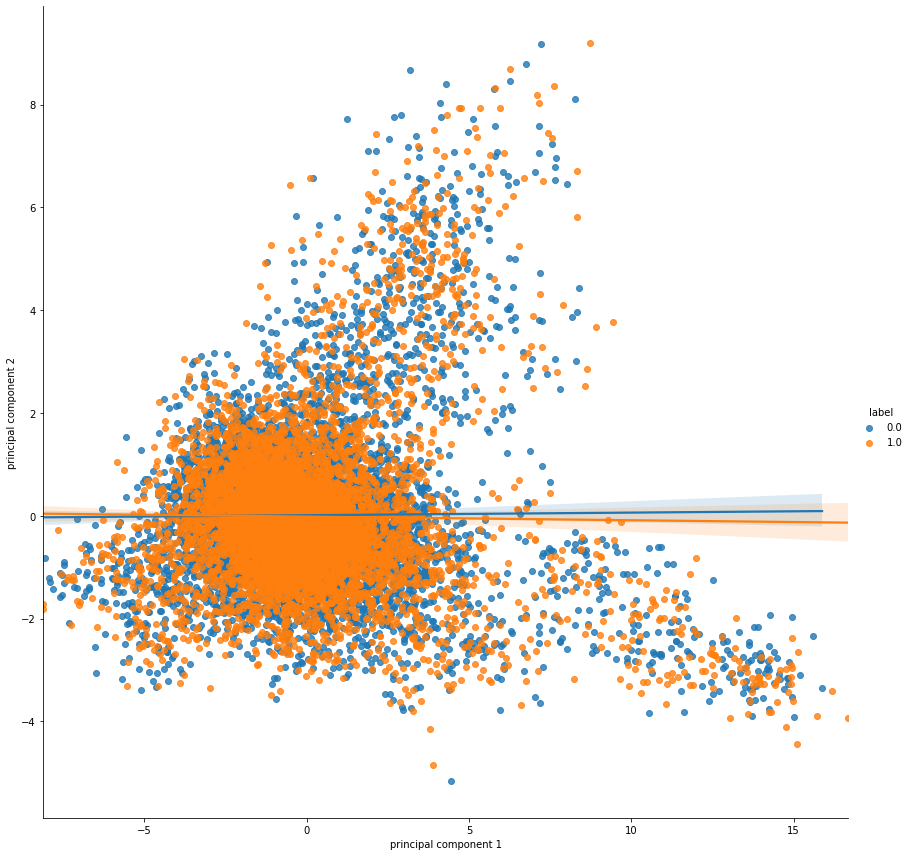

In [33]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf["label"] = y_clean
sns.lmplot(x="principal component 1",y="principal component 2",hue="label",height=12,data=principalDf)

### t-SNE

In [34]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=50).fit_transform(X_norm)
X_embedded

array([[-13.116241,  81.23392 ],
       [ 16.878334, -10.307433],
       [-59.402683, -33.759834],
       ...,
       [-62.577835,  45.391808],
       [-43.247047, -27.327175],
       [ 41.46603 , -52.490993]], dtype=float32)

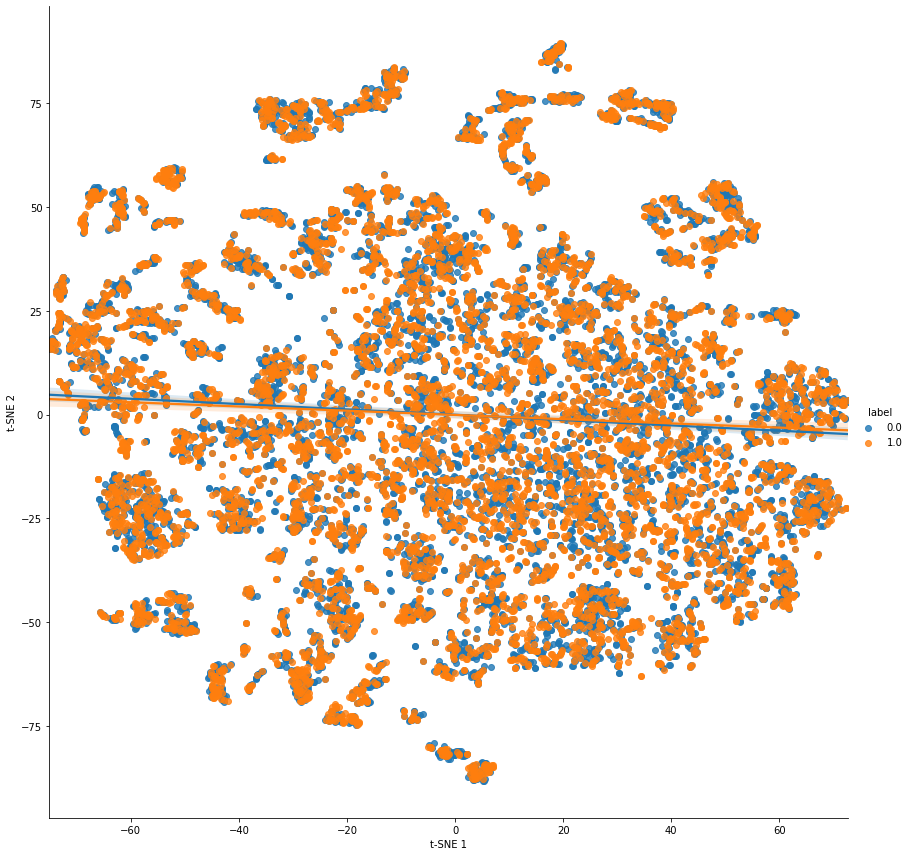

In [35]:
principalDf = pd.DataFrame(data = X_embedded
             , columns = ['t-SNE 1', 't-SNE 2'])
principalDf["label"] = y_clean
sns.lmplot(x="t-SNE 1",y="t-SNE 2",hue="label",data=principalDf,height=12)

#### !The regression lines indicate the labels are distributed randomly.

### k-means on t-SNE projection

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0).fit(principalDf[['t-SNE 1', 't-SNE 2']])
principalDf["kmeans"] = kmeans.labels_

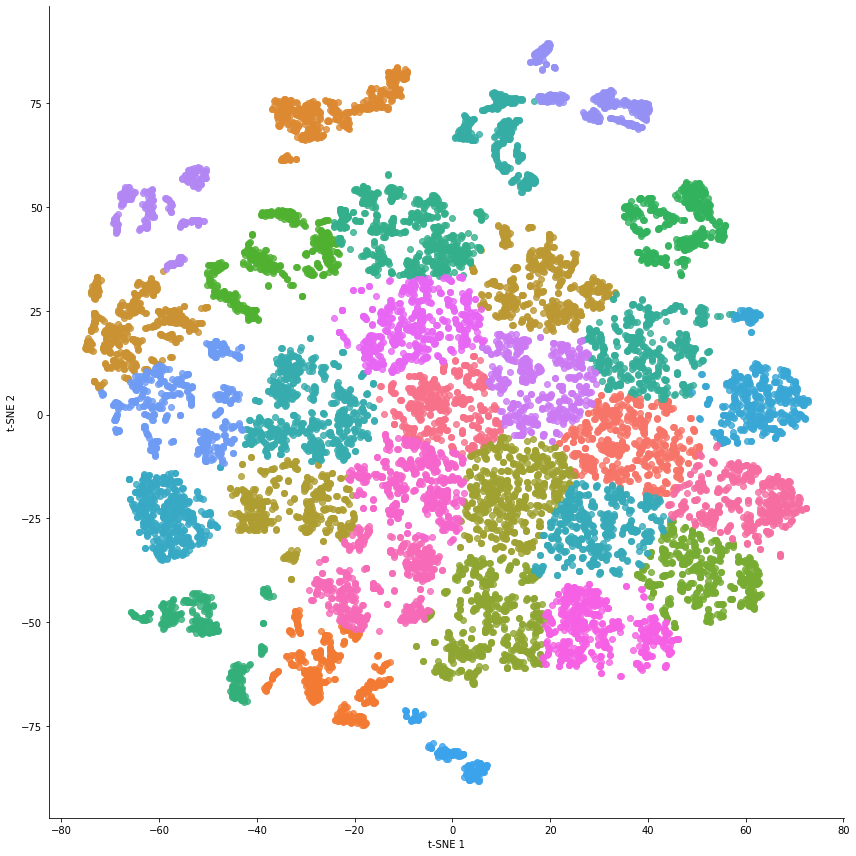

In [37]:
sns.lmplot(x="t-SNE 1",y="t-SNE 2",hue="kmeans",fit_reg=False,legend=False,data=principalDf,height=12)

In [0]:
X_clean["cluster"] = kmeans.labels_
X_clean["label"] = y_clean

In [39]:
len(kmeans.labels_)

14892

In [40]:
X_clean

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,cluster,label
437,4299.49,3979.49,4249.23,4080.51,4328.72,4617.95,4103.59,4637.95,4217.44,4235.38,4183.59,4301.03,4624.10,4371.79,3,1
8337,4289.74,4001.03,4263.08,4137.44,4342.56,4617.95,4055.38,4619.49,4197.95,4231.79,4193.33,4273.85,4593.33,4342.05,7,1
14100,4293.33,4046.15,4250.77,4132.31,4344.10,4625.64,4068.21,4593.33,4187.18,4207.69,4191.79,4264.10,4601.03,4342.05,18,0
4027,4280.00,4004.62,4264.62,4109.74,4330.77,4612.31,4043.08,4603.08,4173.85,4204.10,4179.49,4261.54,4590.77,4325.13,26,1
6500,4274.87,3986.15,4255.90,4102.56,4326.15,4623.08,4054.87,4616.41,4190.26,4208.21,4187.69,4281.54,4602.05,4349.23,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,4443.59,4090.77,4293.33,4153.33,4350.77,4622.05,4070.26,4597.95,4201.03,4258.46,4238.46,4309.23,4669.23,4476.41,4,0
12252,4274.87,4055.38,4272.82,4167.69,4362.56,4634.87,4080.00,4631.79,4180.51,4206.15,4173.33,4261.54,4554.87,4306.15,15,0
1346,4356.92,3977.44,4277.44,4105.64,4326.67,4587.18,4079.49,4607.18,4197.44,4247.69,4257.95,4308.21,4704.62,4451.28,23,1
11646,4287.18,4015.90,4249.74,4110.26,4349.74,4622.56,4072.31,4595.38,4187.18,4227.18,4202.05,4253.85,4592.82,4355.90,6,1


In [54]:
kmeans.n_clusters

30

In [62]:
import random
tr =  random.sample(range(0, 30), 15)
tr

[10, 17, 5, 16, 11, 25, 27, 2, 20, 8, 12, 24, 7, 6, 3]

In [0]:
trainset = X_clean[X_clean["cluster"].isin(tr)]
testset = X_clean[~X_clean["cluster"].isin(tr)]

In [75]:
print(trainset["label"].value_counts())
print(testset["label"].value_counts())

0    3917
1    3509
Name: label, dtype: int64
0    4255
1    3211
Name: label, dtype: int64


In [0]:
trainset.pop("cluster")
testset.pop("cluster")
testlabels = pd.DataFrame()
testlabels["label"] = testset.pop("label")

In [0]:
trainset.to_csv("eeg_train.csv",index=False)
testset["index"] = [i for i in range(len(testset))]
testset.to_csv("eeg_test.csv",index=False)
testlabels["index"] = [i for i in range(len(testlabels))]
testlabels.to_csv("eeg_test_labels.csv",index=False)

tmp = pd.DataFrame()
tmp["index"] = [i for i in range(len(testlabels))]
tmp["label"] = random.choices(range(0,2),k=len(testlabels))
tmp.to_csv("sample_submission.csv",index=False)